In [1]:
#!pip install geopy
#!pip install folium
#!pip install pandas
#!pip install shapely
#!pip install geos
#pip install matplotlib
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import matplotlib.pyplot as plt
import folium
import time
import re
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import random # library for random number generation
import xml.etree.cElementTree as et
from geopy.geocoders import Nominatim
from IPython.display import Image 
from IPython.core.display import HTML
from pandas.io.json import json_normalize
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from ast import literal_eval


In [2]:
# Read from KML file the electoral district coordinate (Done)
# Convert them into GeoJSON format that folium need (Done)
# Read data from the other file, see how to convert from postal code to lat lon (Done)
# Then figure out a way to check whether a point exists with a polygon (Done)
# Ok, now I can get the latlon for each point that I have address, I can create the dataframe I need: (Done)
# [name, coordinate, venue_type,district] (Done)
# For each point, loop through all polygon until it found a match, then assign the district (Done)
# Add shopping malls(Done)
# Run through the whole list to get the district
# Then pivot the data and find all the different venue type for each district
# Plot histogram and  for all district
# Then see how to display this information on the map
# And that is it for my coursera capstone project!!!!!


Inspecting the eating establishment file revealed that there are duplicted entries with the same postal code. Steps to remove the duplicates are neccessary

Introduction:
This project aims to count the number of different type of amenities (shopping mall, school etc) present in the different electoral division of Singapore. Having this data allow us to quantify the convenience of living of each electoral division. 

Step 1: Get the data
Most of the data requires for this project can be found on https://data.gov.sg/ , a website built by the Singapore government to provide open data to developers. The first data this project needs is the polygon of coordinates that mark the boundary of each electoral division in Singapore. The data.gov.sg site does not provide the specific data I need, it only provide the KMZ file that can be found on this page https://data.gov.sg/dataset/electoral-boundary_2020 , some data extraction work is needed to get the geospatial data in the specific format I needed. The KML file I downloaded and used is present in the project folder.
The data.gov.sg also provide csv files that record down various amenities and their addresses, however, it does not contain their coordinates, which is required for determining which electoral division they belong to. In order to get their coordinates, I need to invoke the API provided by https://www.onemap.gov.sg, which is a website built by Singapore Land Authority. The various csv files I downloaded and used are located in the project folder too. 

Step 2: Explore and clean the data
In this step, I will explore the data and see whether they fit the project's needs. For each of the amenities, I need the coordinates of each amenities, for this I need to extract out their postal code and call the API proivided by https://www.onemap.gov.sg. Looking into the csv files, I can see there are 2 different formats in which the postal code are written, and they are located in differently named column in each file. I also need to need to drop the other redundant columns, leaving only the name and the postal code of the amenities. To automate these tasks, I have written the following funcitons

In [4]:
# To get the Regex pattern required for each different dataframe and its column that contain the address
rgxPattern1 = '[Ss]\([0-9/]{6,}\)'
rgxPattern2 = '\\b[0-9]{6}\\b'
rgxList = [rgxPattern1, rgxPattern2]
def getRegExPatternAndAddressColumnHeading(df):
    firstRow = df.iloc[0]
    for index, value in firstRow.items():
        i = 0
        while i < len(rgxList):
            if type(value) != str:
                value = str(value)
            match = re.search(rgxList[i], value)
            if match:
                return [index, i]
            i+=1
    return ['None', 'None']

In [5]:
# To get the column heading of the dataframe that contain the name of the amenities
def getNameColumnHeading(columns):
    pattern = 'name'
    prog = re.compile(pattern)
    for heading in columns:
        match =prog.search(heading)
        if match :
            return heading
    return 'None'


In [6]:
# To use regex to extract the postal code from a row of dataframe
def regexSearch(x,heading,prog,patternIndex):
    match = prog.search(str(x[heading]))
    if match:
        if patternIndex == 0:
            return match.group(0)[2:8]
        elif patternIndex == 1:
            return match.group(0)
    else:
        return np.nan


In [7]:
# To extract name of amenities and its postal code from a dataframe
def extractPostalCodeFromDf(df, addressheading, patternIndex):
    prog = re.compile(rgxList[patternIndex])
    df['Postal_Code'] = df.apply(lambda x: regexSearch(x, addressheading, prog, patternIndex), axis = 1)
    nameHeading = getNameColumnHeading(df.columns)
    return df[[nameHeading, 'Postal_Code']]



I also need to extract the polygon of coordinates of each electoral divison from the KML file. For this I need to study and parse the KML file to extract the information I need. The following function I wrote can achieve this.

In [8]:
# Extract polygon of each divison from the KML file
def extractCoorFromKML():
    tree=et.parse('./Data/map.Kml')
    root=tree.getroot()
    result = []
    
    for i in root[0][3].iter('{http://www.opengis.net/kml/2.2}Placemark'):
        for j in i[4].iter('{http://www.opengis.net/kml/2.2}Polygon'):
            nameCoorPair = []
            nameCoorPair.append(i[0].text)
            nameCoorPair.append(j[2][0][0].text)
            result.append(nameCoorPair)
        # nameCoorPair = []
        # nameCoorPair.append(i[0].text)
        # nameCoorPair.append(i[4][0][2][0][0].text)
        # result.append(nameCoorPair)

    return result

In [9]:
# Coordinate information extract is in string format, this function convert them into tuple of float 
def convertStrToTupleOfPoint(coorStr):
    CoorStr = coorStr.lstrip()
    if(coorStr.endswith(',0')):
        coorStr = coorStr.rstrip(',0')
    coorStrList = coorStr.split(',0 ')
    result = []
    for coor in coorStrList:
        splitCoor = coor.split(',')
        coorTuple =(float(splitCoor[1]), float(splitCoor[0]))
        result.append(coorTuple)
    return result

Step 3: Enrich the data
With the postal code extract from the original data, I can call the API of https://www.onemap.gov.sg with the postal code as the search term and retrieve the coordinate of each amenity. The following 3 functions I wrote are used to achieve that.

In [10]:
def getCoordinatesForDF(df):
    # if df is greater than 250 , split
    if(len(df.index) > 250):
        x = (len(df.index) / 250)
        dfArray = []
        i = 1
        startIndex = 0
        endIndex = 249
        while i < x:
            splitDf = df.loc[startIndex:endIndex]
            dfArray.append(splitDf)
            i+=1
            startIndex = startIndex + 250
            endIndex = endIndex + 250
        print('{one} and {two}'.format(one = startIndex, two = endIndex))
        dfArray.append(df.loc[startIndex:len(df.index)-1])
        resultColumn = df.columns.append(pd.Index(['Coordinates']))
        resultDf = pd.DataFrame(columns=resultColumn)
        for item in dfArray :
            print('Getting data ...')
            resultDf = resultDf.append(limitAPICallPerMinute(item))
            time.sleep(60)
        return resultDf
    else:
        print('Getting data ...')
        result = limitAPICallPerMinute(df)
        time.sleep(60)
        return result


In [11]:
def limitAPICallPerMinute(df):
    df['Coordinates'] = df.apply(lambda x: getLatLonFromSearchTerm(x['Postal_Code']), axis = 1)
    return df

In [12]:
def getLatLonFromSearchTerm(SearchTerm):
    r = requests.get('https://developers.onemap.sg/commonapi/search?searchVal={searchVal}&returnGeom=Y&getAddrDetails=Y&pageNum=1'.format(searchVal = SearchTerm))
    # process r as a json
    lat = 0
    lon = 0
    try:
        lat = r.json()["results"][0]['LATITUDE']
        lon = r.json()["results"][0]['LONGITUDE']
    except:
        return np.nan
    return [float(lat),float(lon)]



To assemble all the smaller subtasks to get amenity with coordinate information together, I consolidate all the steps into one dataWrangling function. In this function, I need to input a list of the amenity csv files that I downloaded from the https://data.gov.sg/, and a list of the corresponding venue type.

In [13]:
def dataWrangling(csvList, venueTypeList):
    processedDFList = []
    i = 0
    while i < len(csvList):
        df = pd.read_csv('./Data/{csvFile}'.format(csvFile = csvList[i]))
        result = getRegExPatternAndAddressColumnHeading(df)
        if (result[0] == 'None'):
            i+=1
            continue
        #Uncomment to test out only the first 5 entries of each csv
        #df = df.head(5)
        dfWithPostalCode = extractPostalCodeFromDf(df, result[0],result[1])
        # Remove entries with same name and postal code
        dfWithPostalCode = dfWithPostalCode.drop_duplicates()
        # Remove entry with empty postal code
        dfWithPostalCode = dfWithPostalCode.dropna(subset=['Postal_Code'])
        dfWithCoordinate = getCoordinatesForDF(dfWithPostalCode)
        # Remove entry with coor = np.nan
        dfWithCoordinate = dfWithCoordinate.dropna(subset=['Coordinates']) 
        dfWithCoordinate['Venue_Type'] = venueTypeList[i]
        dictionary = {getNameColumnHeading(dfWithCoordinate): 'Name', 'Postal_Code': 'Postal_Code', 'Coordinates': 'Coordinates', 'Venue_Type':         'Venue Type'}
        renamedDF = dfWithCoordinate.rename(columns = dictionary)
        # print('After rename')
        processedDFList.append(renamedDF)
        # print(renamedDF.head(3))
        i+=1
    # print(len(processedDFList))
    finalDF = pd.DataFrame(columns = ['Name', 'Postal_Code', 'Coordinates', 'Venue Type'])
    for item in processedDFList:
        # print(item.head(3))
        finalDF = finalDF.append(item, ignore_index=True)
        # print(finalDF.head(3))
    return finalDF

To allocate the amenities into their respective division, I wrote the following functions. In essence, what it does is to check if the coordinates of an amenity exists within the polygon of an electoral division, if so, assign the division to the amenity.

In [14]:
def isPointWithinPolygon(point, polygon):
    convertedPoint = Point(point)
    convertedPolygon = Polygon(polygon)
    return (convertedPolygon .contains(convertedPoint))

In [15]:
def checkDistrict(coordinate,areaDf):
    i = 0
    while i < len(areaDf):
        if(isPointWithinPolygon(coordinate, areaDf.loc[i,'Coor'])):
            return areaDf.loc[i,'Area']
        i+=1
    return 'Unknown'

Step 4: Add Data visualisation
After allocating each amenity into their respective division, I added function to plot horizontal bar chart with the data.

In [16]:
def plotVenueCountBarChart(district, dataframe):
    # select only rows of the district
    dataframe = dataframe[dataframe['District'] == district]
    # generate a list of [venue : count] tuple
    venueCountSeries = dataframe['Venue Type'].value_counts()
    yLabels = venueCountSeries.index.to_numpy()
    xValues = venueCountSeries.to_numpy()
    # use this to plot bar chart
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    width = 0.75
    ind = np.arange(len(yLabels))
    ax.set_yticks(ind)
    ax.set_yticklabels(yLabels, minor=False)
    ax.set_facecolor('#659EC7')
    for i, v in enumerate(xValues):
        ax.text(v + 3, i, str(v), color='black', fontweight='bold')
    plt.title('Count of venue in {district}'.format(district = district))
    plt.xlabel('Count of venue')
    plt.ylabel('Venue Type')
    out = ax.barh(ind, xValues, width, color='#BDEDFF')
    return out


In [17]:
def plotCountOfOneVenueTypeInAllDistricts(venueType, dataframe):
    # select only rows of the venue
    dataframe = dataframe[dataframe['Venue Type'] == venueType]
    # generate a list of [venue : count] tuple
    districtCountSeries = dataframe['District'].value_counts()
    yLabels = districtCountSeries.index.to_numpy()
    xValues = districtCountSeries.to_numpy()
    # use this to plot bar chart
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    width = 2
    ind = np.arange(len(yLabels))
    ax.set_yticks(ind*(width*1.5))
    ax.set_yticklabels(yLabels, minor=False)
    ax.set_facecolor('#659EC7')
    for i, v in enumerate(xValues):
        ax.text(v + 0.3, i*(width*1.5), str(v), color='black', fontweight='bold')
    plt.title('Count of {venue} in each district'.format(venue = venueType))
    plt.xlabel('Count of {venue}'.format(venue = venueType))
    plt.ylabel('District')
    out = ax.barh(ind*(width*1.5), xValues, width, color='#BDEDFF')
    return out


The following is the main code body that will generate the final result we want.

In [18]:
# This block of code will generate a dataframe with 2 columns, 'Area' and 'Coor', it will be used to check which area (electoral division) the amenity belongs to
divisionPolygon = extractCoorFromKML()
divisionPolygonDF = pd.DataFrame(divisionPolygon, columns = ['Area','Coor'])
divisionPolygonDF['Coor'] = divisionPolygonDF.apply(lambda x: convertStrToTupleOfPoint(x['Coor']), axis = 1)

In [19]:
# This block of code will loop through all the 6 amenity csv files and generate a dataframe that combine together the information of all different types of amenity with their coordinates
# However, it will take a long time (5 hours plus) to process the data, so I have provided the final csv file in the project folder to be use,
# instead of generating it from scratch 
csvList = ['list-of-government-markets-hawker-centres.csv', 'list-of-nea-licensed-eating-establishments.csv', 'list-of-supermarket-licences.csv', 'listing-of-centres.csv', 'listing-of-licensed-pharmacies.csv', 'general-information-of-schools.csv' ]
venueTypeList = ['Hawker Centre', 'Eating Establishment', 'Super Market', 'Preschool Centre', 'Pharmacies', 'School']
#processedDF = dataWrangling(csvList, venueTypeList)
#processedDF.to_csv('processedData.csv')
#processedDF['District'] = processedDF.apply(lambda x: checkDistrict(x['Coordinates'],divisionPolygonDF), axis = 1)
#processedDF.to_csv('./processedDataWithDivision.csv')

In [21]:
# i feels that shopping mall is also an amenity that people will be interested in. However, I cannot find relevant information  on data.gov.sg, so I decided to
# create a csv file of all shopping malls in Singapore and process it in a way similar to the above step in order to find out which district (electoral division)
# it belongs to 
shoppingMallDF = pd.read_csv('./Data/Shopping_malls_Singapore.csv')
shoppingMallDF['Postal_Code'] = 'None'
shoppingMallDF['Coordinates'] = shoppingMallDF.apply(lambda x: getLatLonFromSearchTerm(x['Name']), axis = 1)
shoppingMallDF['Venue Type'] = 'Shopping Mall'
shoppingMallDF = shoppingMallDF.dropna(subset=['Coordinates'])
shoppingMallDF['District'] = shoppingMallDF.apply(lambda x: checkDistrict(x['Coordinates'],divisionPolygonDF), axis = 1)
shoppingMallDF.to_csv('./shoppingfile.csv')


In [22]:
#To merge the 2 dataframe together and use them in the final data visualisation step
processedDF = pd.read_csv('./processedDataWithDivision.csv')
shoppingCentreDF = pd.read_csv('./shoppingfile.csv')
processedDF = processedDF.append(shoppingCentreDF)
processedDF = processedDF.drop(columns =['Unnamed: 0'])
processedDF = processedDF.reset_index(drop=True)

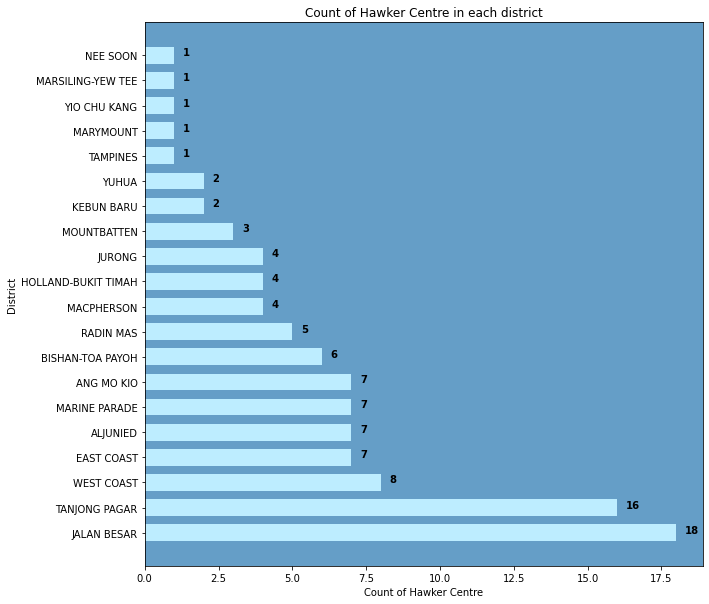

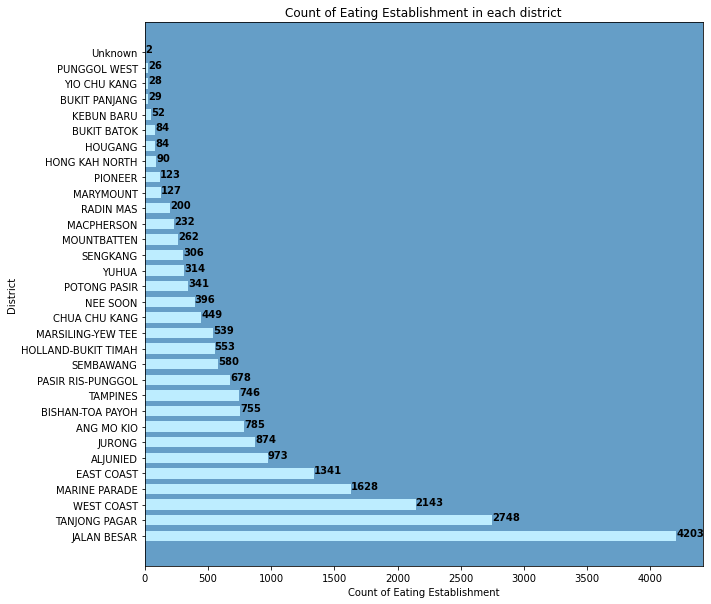

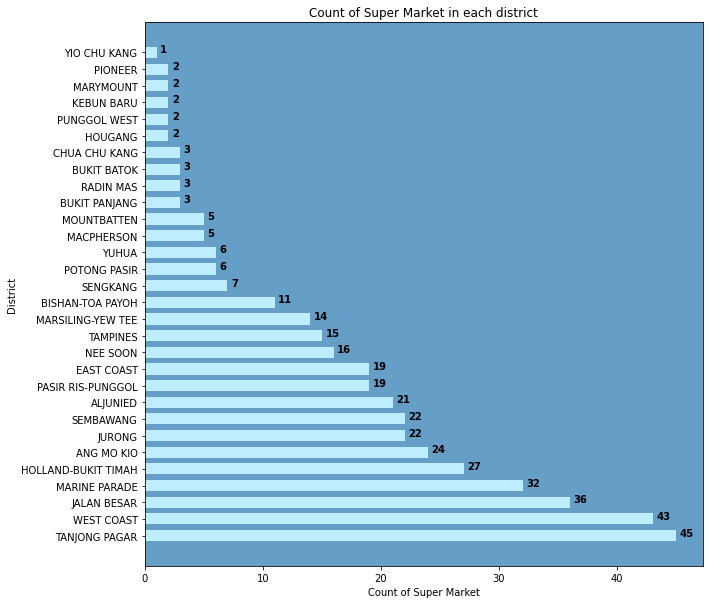

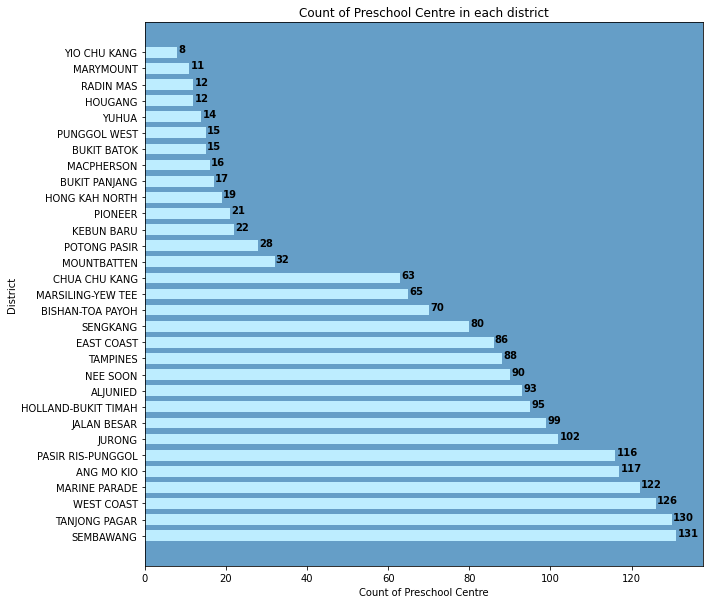

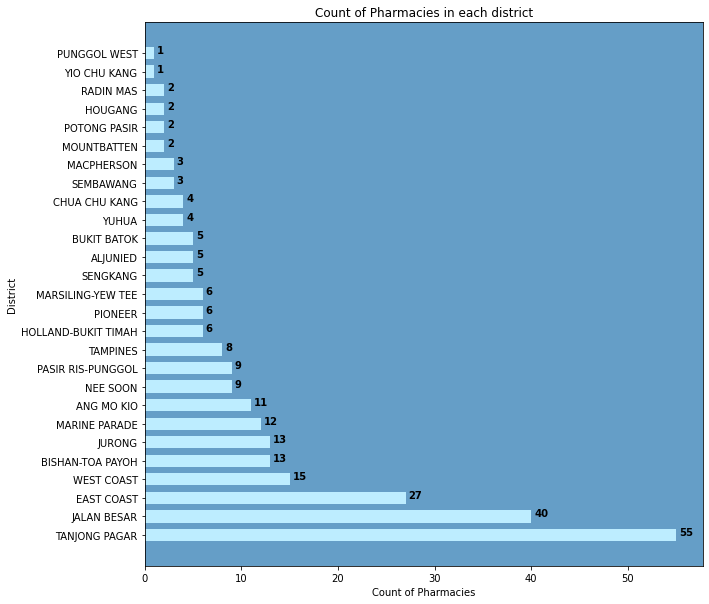

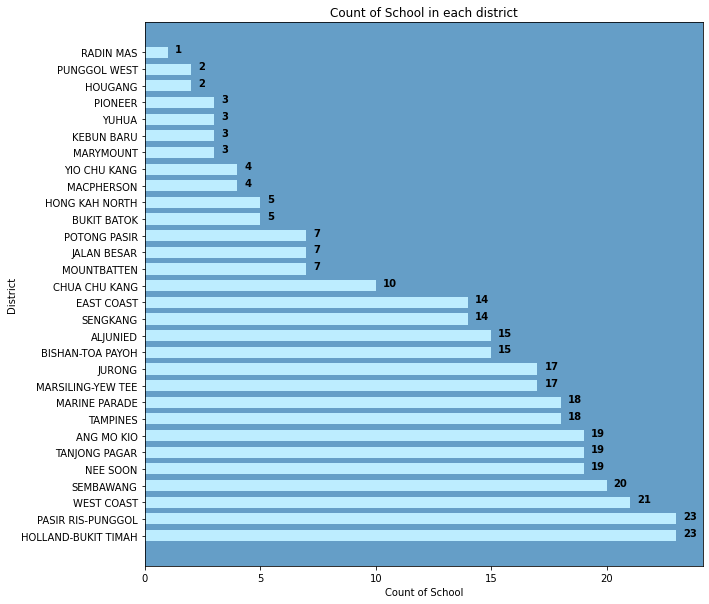

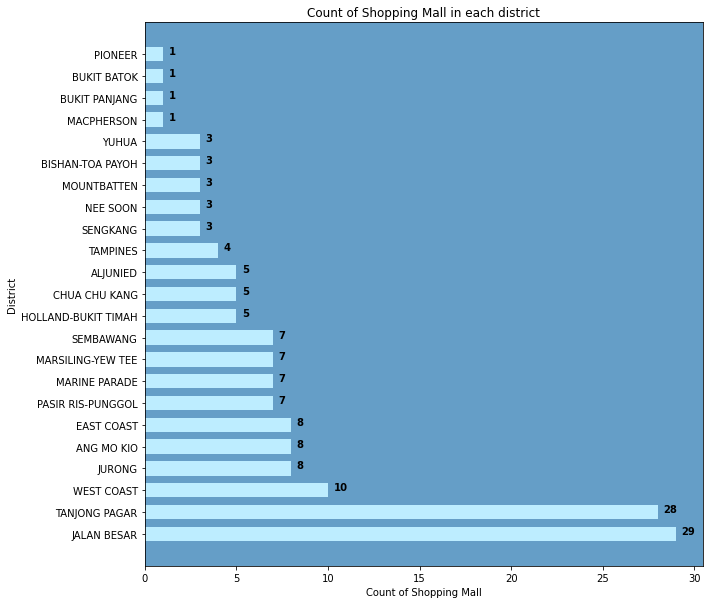

In [23]:
#get a list of all venue type
venueTypeList = processedDF['Venue Type'].unique()
for venueType in venueTypeList:
    plotCountOfOneVenueTypeInAllDistricts(venueType, processedDF)

<ipython-input-16-a2834387ef05>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


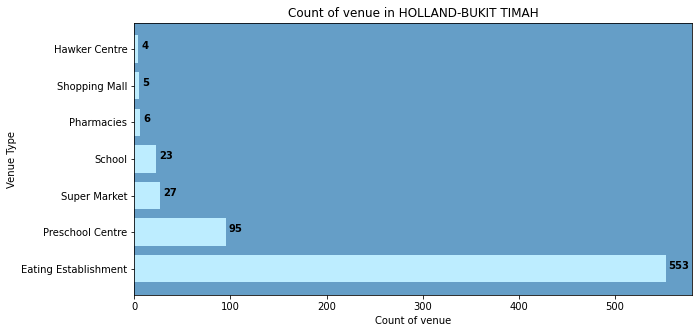

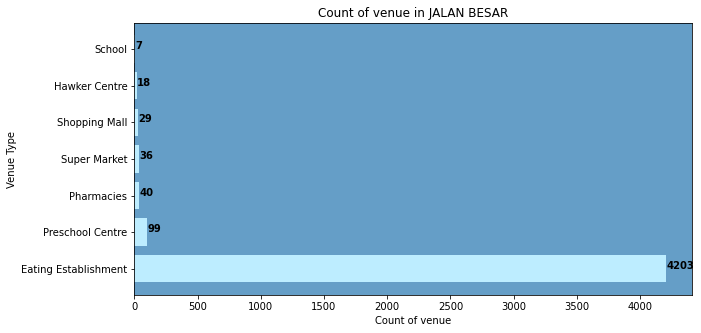

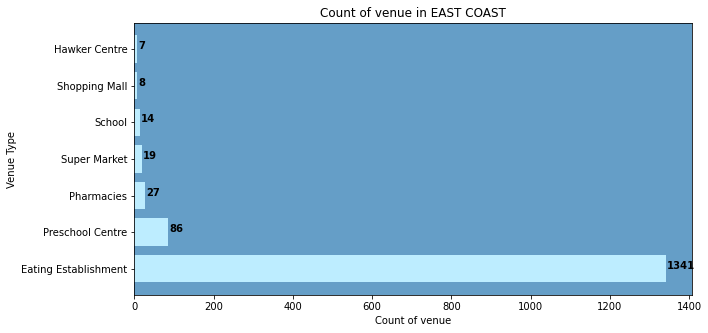

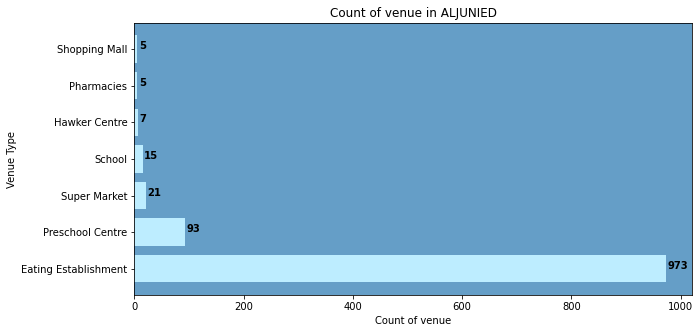

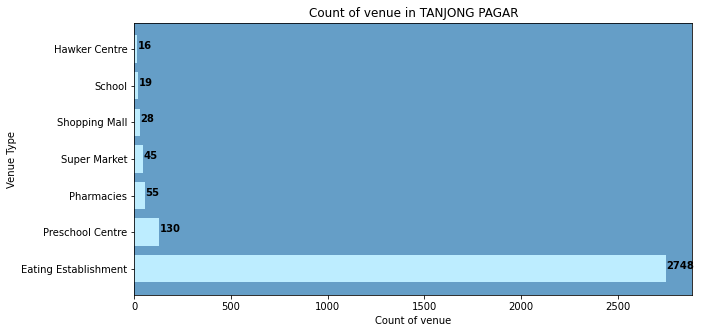

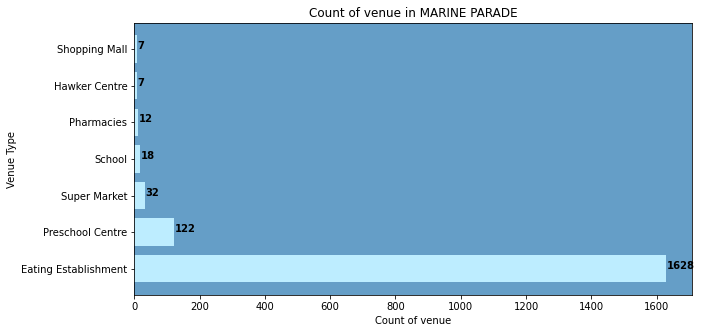

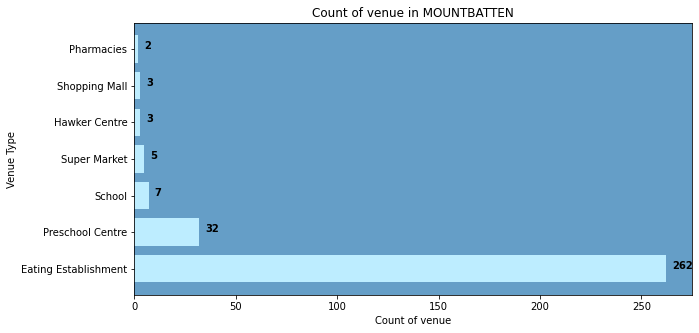

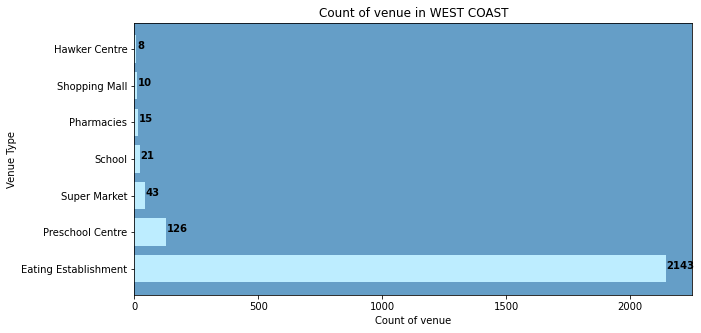

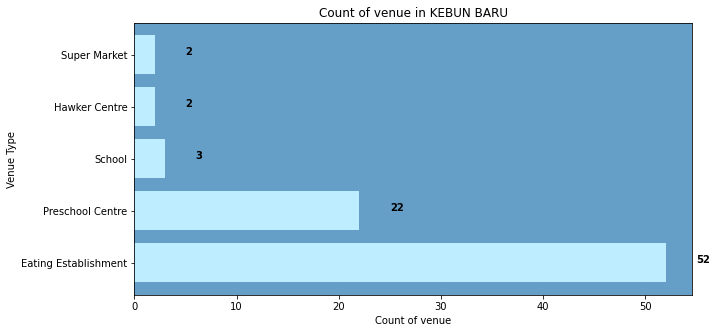

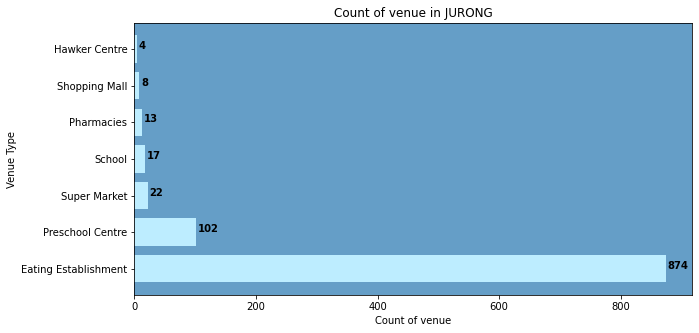

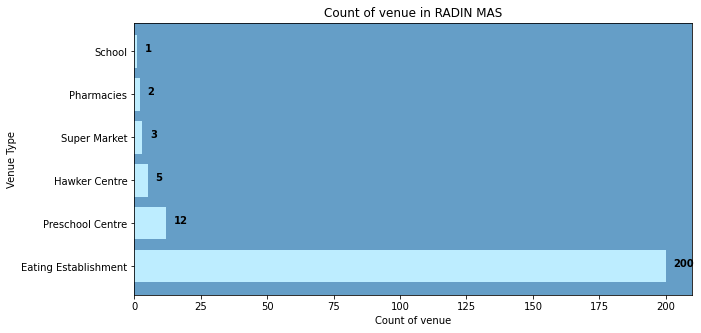

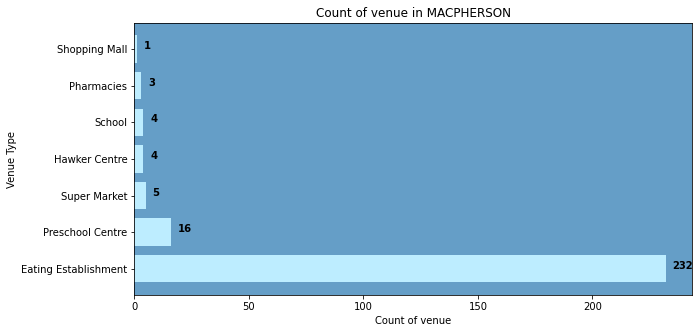

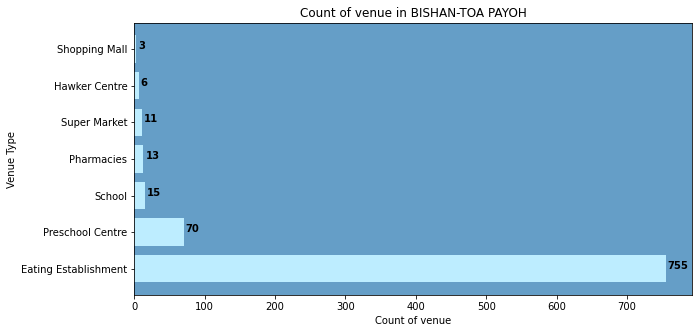

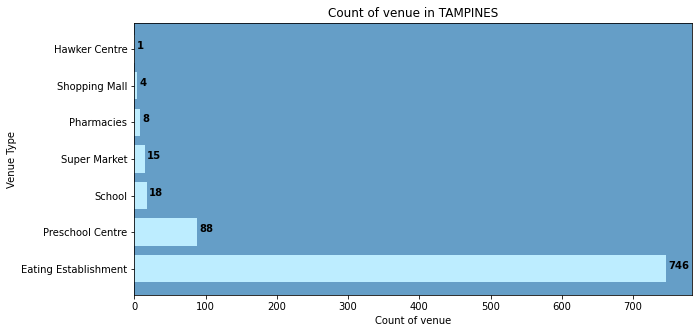

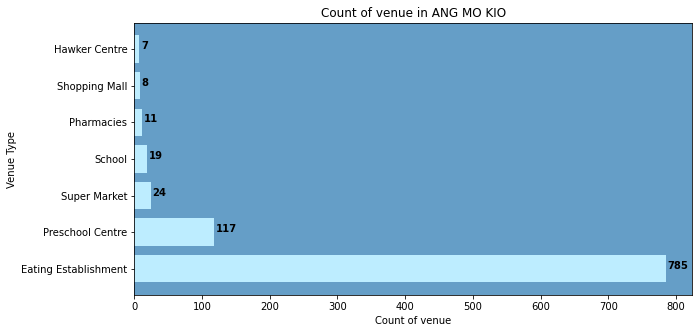

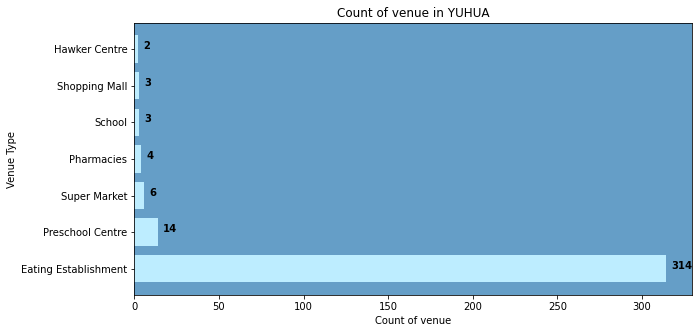

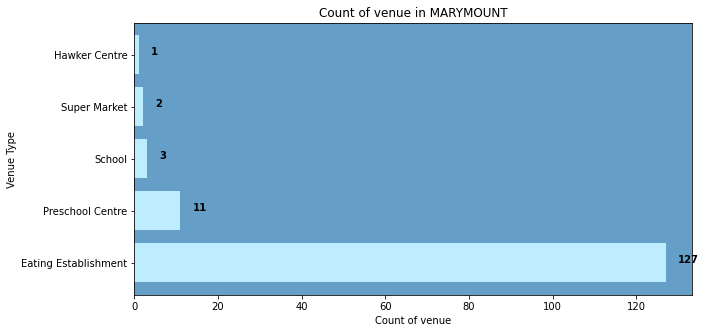

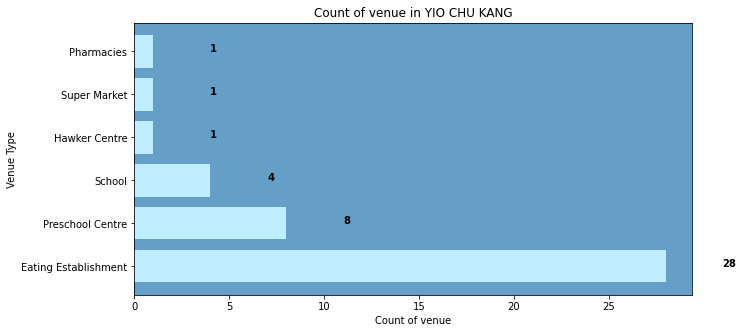

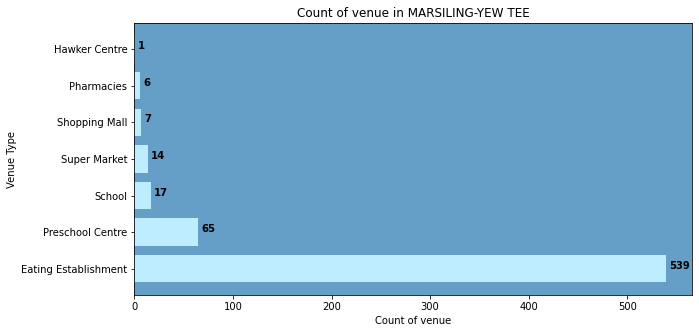

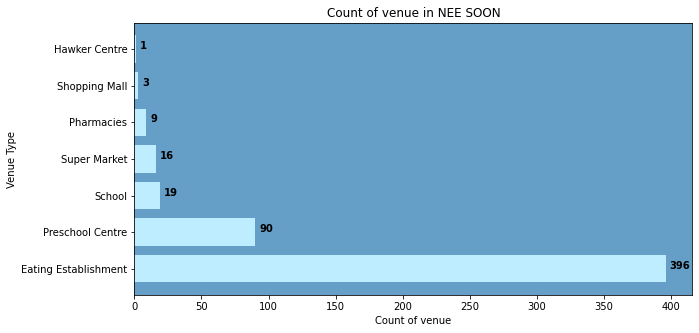

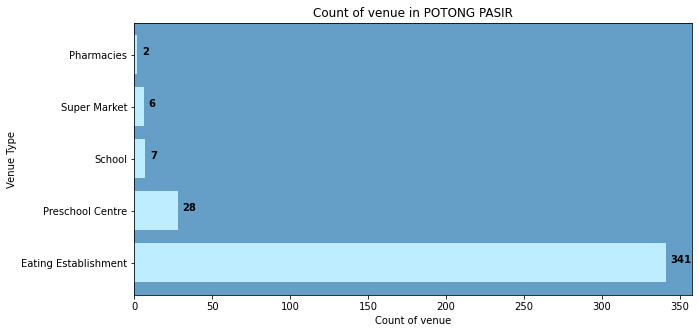

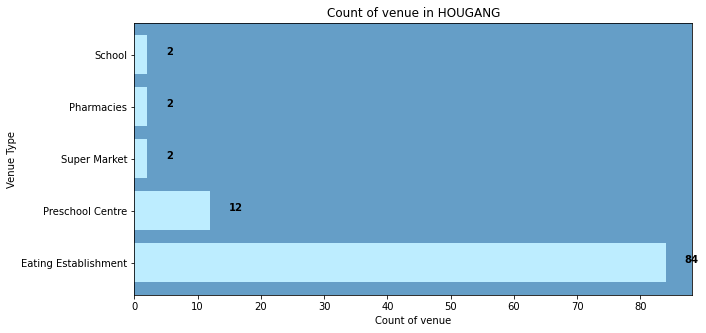

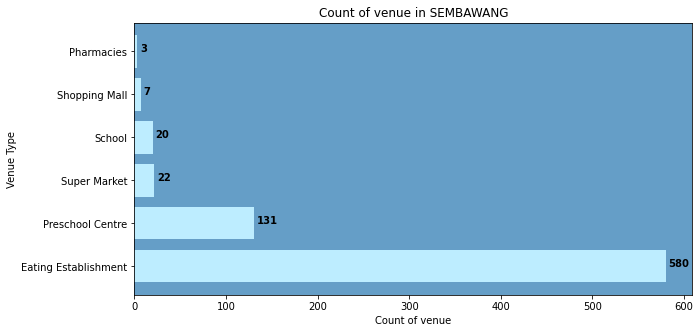

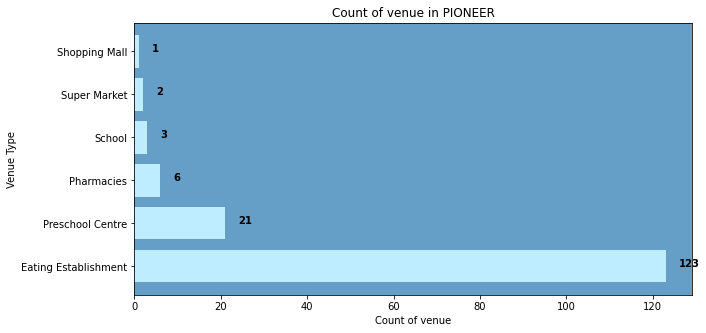

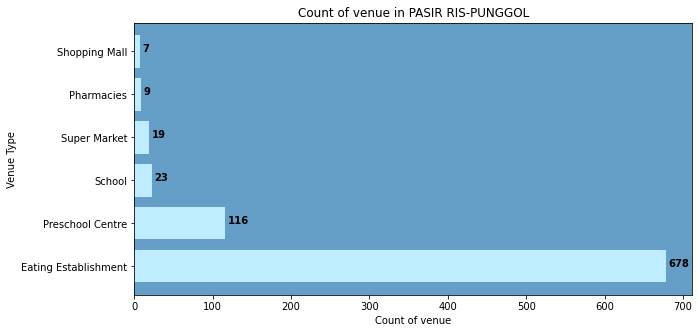

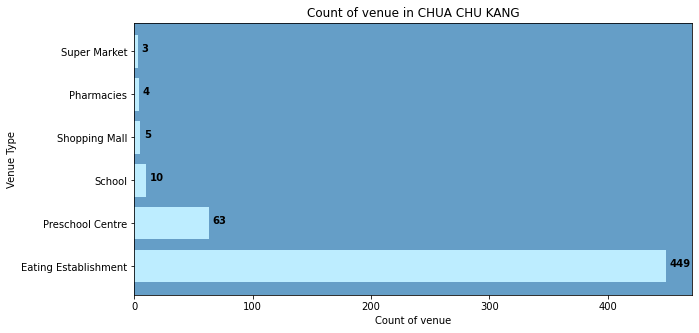

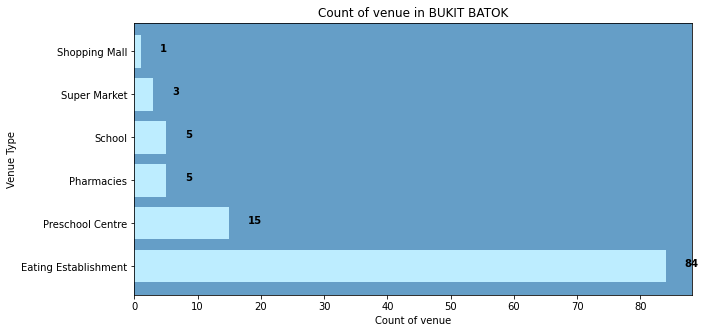

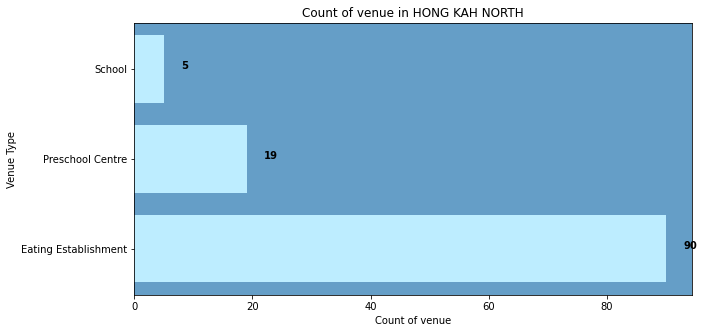

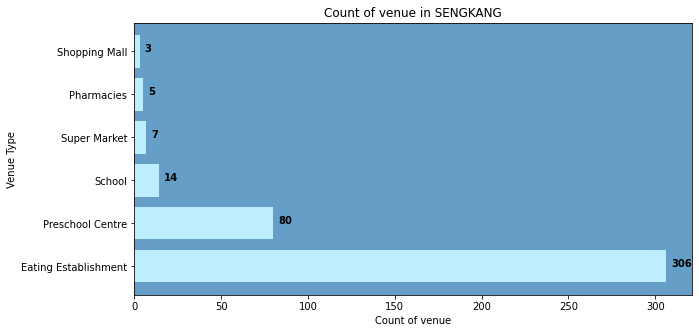

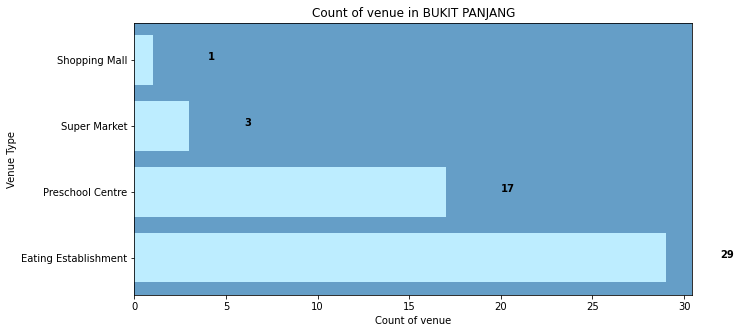

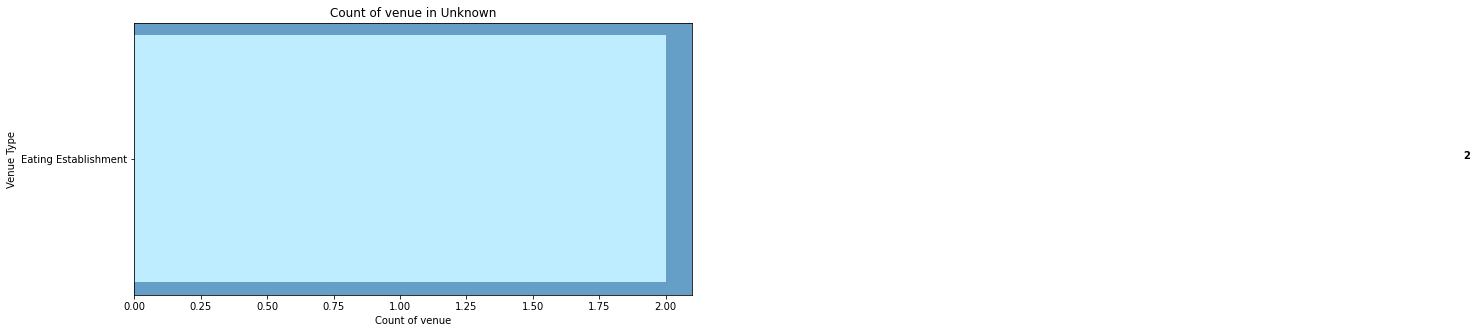

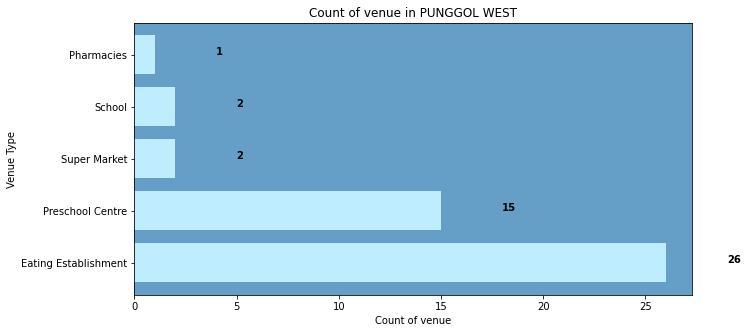

In [24]:
#get a list of all district
districtList = processedDF['District'].unique()
for district in districtList:
    plotVenueCountBarChart(district, processedDF)